# Capstone Project 1: Data Story

### Data Pre-processing
Capstone Project 1: Data Wrangling

Google link: https://docs.google.com/document/d/1EBtoL05Ir64pk1aDLzz0nKp1YVikfVR0fGMQv5lTsqg/edit?usp=sharing

Steps:

Create a Google Doc (1-2 pages) describing the data wrangling steps you took to clean the dataset. Include answers to these questions in your submission:

What kind of cleaning steps did you perform?

Drop unnecessary columns
- Apply datetime format
- Calculate 24 month customer lifetime revenue by using order table based on item order data set
- Get first order revenue per customer based on item order data set
- Create dataset on customer_id level: contains all first order infomation + first order reveue + 24 month lifetime revenue
- How did you deal with missing values, if any?

del rows since only 2 missing values for each column
Were there outliers, and how did you handle them? keep outliers since those are extreme values - some customers submitted large orders

Submit a link to the document.

Discuss it with your mentor at the next call.

Revise and resubmit if needed.

Convert the final document to a .pdf and add it to your GitHub repository for this project. This document will eventually become part of your milestone report.

In [1]:
# from google.colab import files
import io

#uploaded = files.upload()
# df.to_csv('df.csv')
# files.download('df.csv')

import pandas as pd
pd.set_option('display.max_columns', None)
pd.plotting.register_matplotlib_converters()
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


import seaborn as sns
sns.set(rc={'figure.figsize':(16.7,6.27)})


from plotly.offline import init_notebook_mode, iplot # plotly offline mode
init_notebook_mode(connected=True) 
import plotly.graph_objs as go # plotly graphical object

import os
# print(os.listdir("../input"))

import warnings            
warnings.filterwarnings("ignore") 

from pandas import datetime
import datetime

# Basic  EDA
from sklearn.externals.six import StringIO
import statsmodels.api as sm
from scipy import stats
from sklearn import preprocessing

# load helper functions
# find the unique values in each column
def unique_counts(customer):
    for i in customer.columns:
        count=customer[i].nunique()
        print(i, ':', count)
        

#print missing value table
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values ', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns  

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [2]:
customer=pd.read_csv('https://drive.google.com/uc?export=download&id=1wv4GrazmaBO4wd6FuNay7pillVkUzzs7')
# customer=pd.read_csv('/Users/lylay/Desktop/spring board/bb_customer')
# order=pd.read_csv('/Users/lylay/Desktop/spring board/bb_order.csv')
order=pd.read_csv('/Users/yangx/Documents/reference/bb_order.csv')

In [3]:
print(customer.dtypes)
print()
print(customer.head())
print()
print('rows and cols of cutomer data:', customer.shape)
print()
print(order.head())
print('rows and cols of cutomer data:', order.shape)

customer_id                                 int64
registered_date                            object
email_address                              object
postal_code                                object
state_or_province                          object
fo_order_channel                           object
fo_origin                                  object
fo_f_item                                  object
fo_f_category                              object
fo_f_product                               object
fo_ga_channel                              object
fo_qm_channel                              object
fo_qm_publisher                            object
fo_qm_device                               object
fo_custom_flag                            float64
fo_company_name_flag                      float64
fo_discount_flag                          float64
fo_ffr_flag                               float64
fo_quote_flag                             float64
fo_upload_flag                            float64


In [4]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218367 entries, 0 to 218366
Data columns (total 35 columns):
customer_id                               218367 non-null int64
registered_date                           218367 non-null object
email_address                             218367 non-null object
postal_code                               119662 non-null object
state_or_province                         119662 non-null object
fo_order_channel                          218367 non-null object
fo_origin                                 193456 non-null object
fo_f_item                                 218367 non-null object
fo_f_category                             218367 non-null object
fo_f_product                              218367 non-null object
fo_ga_channel                             207109 non-null object
fo_qm_channel                             210536 non-null object
fo_qm_publisher                           142730 non-null object
fo_qm_device                              141

## Step 1: calculate first order revenue and 24 month lifetime revenue per customer
Use order(on item level) to calculate first order revenue per customer
And 24month customer lifetime revenue per customer by summing up all order reveue for each customer within 730 days since the first order date

In [5]:
# drop cols
cols_to_drop=['item_id', 'Unnamed: 22','Unnamed: 21','p5','p7','p3','p2','p6']
order.drop(cols_to_drop, axis=1, inplace=True)

# apply datetime format
order['order_date'] =  pd.to_datetime(order['order_date'], infer_datetime_format=True)
order2=order.groupby(['customer_id'])['order_date'].min().reset_index(name='min_order_date')
order=pd.merge(order, order2, on='customer_id')
order['cut_date_24m']= order.min_order_date + datetime.timedelta(days=730)

# Calculate 24 month lifetime revenue and create column: revenue_24m
df1=order.groupby('customer_id').apply(lambda x: x[(x['order_date'] >= x['min_order_date']) & (x['order_date'] <= x['cut_date_24m'])]['revenue'].sum())
df1=df1.reset_index(name='revenue_24m')

## calculate first order revenue

In [6]:
#Create first order info table for each customer based on order data sets
first_order_info= order.loc[order.order_date==order.min_order_date][['customer_id','ga_order_id','page_title','product','item_origin','revenue','facility_name','quantity',
                                                                     'p1','p4', 'shipping_method','address_flag', 'min_order_date']]

# rename column 'revenue' into 'first_order_revenue_item' since the df contains customer info of first order only
first_order_info.rename(columns={'revenue':'first_order_revenue_item'}, inplace=True)

# do a quick check
print(first_order_info.shape)

(443790, 13)


From df1 we know total customer count = 301599 but we have total first order count= 443790 which means some customer order more than one item on their first order. So we need to calculate first order_revenue. This is also aligned with our dataset info.

In [7]:
# do a quick check: first order item per customer
first_order_info[['customer_id','ga_order_id']].groupby('customer_id').count()

,ga_order_id
customer_id,
7172,1
7258,1
7260,1
7354,2
7374,1
...,...
4205403,1
4205410,1
4205419,1


In [8]:
first_revenue= first_order_info.groupby('customer_id')['first_order_revenue_item'].sum().reset_index(name='first_order_total_revenue')

## Step 2: add 24month ltv and first order revenue to the customer dataframe

In [9]:
customer2=customer.merge(first_revenue, on='customer_id').merge(df1, on='customer_id')
customer2.shape

(118651, 37)

In [10]:
customers=customer2.merge(first_order_info[['customer_id','min_order_date']], on='customer_id')
print(customers.shape)
print(customers.min_order_date.max())

(171805, 38)
2018-01-08 00:00:00


In [11]:
print(customers.registered_date.max())
print(customers.registered_date.min())

9/9/17
1/1/17


## Step 3: check data type, missing value 

In [12]:
# call helper function to check missing values
missing_values_table(customers)

Your selected dataframe has 38 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
Unnamed: 32,171805,100.0
Unnamed: 33,171805,100.0
Unnamed: 34,171805,100.0
postal_code,82451,48.0
state_or_province,82451,48.0
fo_qm_device,60785,35.4
fo_qm_publisher,60673,35.3
fo_origin,18253,10.6
fo_ga_channel,9191,5.3
fo_qm_channel,6653,3.9


In [13]:
# call helper functions to check unique values in each column
unique_counts(customers)  

customer_id : 118651
registered_date : 310
email_address : 37531
postal_code : 18187
state_or_province : 56
fo_order_channel : 3
fo_origin : 3
fo_f_item : 126
fo_f_category : 62
fo_f_product : 14
fo_ga_channel : 11
fo_qm_channel : 11
fo_qm_publisher : 2
fo_qm_device : 3
fo_custom_flag : 2
fo_company_name_flag : 2
fo_discount_flag : 2
fo_ffr_flag : 2
fo_quote_flag : 2
fo_upload_flag : 2
fedex_fo_address_flag : 5
first_order_id : 118651
first_order_source : 1
first_h_item_id : 118651
customer_first_order_own_shipping_flag : 2
count_of_lifetime_orders : 81
count_of_lifetime_items : 133
sum_lifetime_net_sales : 41052
first_order_revenue : 25373
address_flag : 5
Printing_facility : 5
qty_first_order : 166
Unnamed: 32 : 0
Unnamed: 33 : 0
Unnamed: 34 : 0
first_order_total_revenue : 32334
revenue_24m : 40611
min_order_date : 332


In [14]:
# get unique value for each column
for col in list(customers[['fo_order_channel', 'fo_origin', 'fo_ga_channel', 'fo_qm_channel',
       'fo_qm_publisher', 'fo_qm_device', 'fo_custom_flag',
       'fo_company_name_flag', 'fo_discount_flag', 'fo_ffr_flag',
       'fo_quote_flag', 'fo_upload_flag', 'fedex_fo_address_flag',
       'first_order_source', 'customer_first_order_own_shipping_flag', 'address_flag', 'Printing_facility']]):
    print(col)
    print(customers[col].unique())

fo_order_channel
['Online' 'FFR' 'Quotes']
fo_origin
[nan 'Online-Desktop' 'Online-Tablet' 'Online-Mobile']
fo_ga_channel
[nan 'Non-Branded Paid Search' 'Direct' 'PLA' 'Organic Search' 'Referral'
 'Branded Paid Search' 'Social' 'Email' '(Other)' 'Paid Search' 'Display']
fo_qm_channel
['Non-Brand SEM' 'Direct' 'Shopping' 'Organic Search' 'Referral'
 'Brand SEM' nan 'Social' 'Email' 'Display' '(Other)' 'Paid Search']
fo_qm_publisher
['Google' nan 'Bing']
fo_qm_device
['computer' nan 'mobile' 'tablet']
fo_custom_flag
[0. 1.]
fo_company_name_flag
[0. 1.]
fo_discount_flag
[0. 1.]
fo_ffr_flag
[0. 1.]
fo_quote_flag
[0. 1.]
fo_upload_flag
[1. 0.]
fedex_fo_address_flag
['Residential' 'Business' 'Unknown' 'Pickup' 'Mixed']
first_order_source
[1]
customer_first_order_own_shipping_flag
['n' 'y']
address_flag
['Residential' 'Business' 'Unknown' 'Pickup' 'Mixed']
Printing_facility
['Van Nuys' 'Arlington' 'Saddle Brook' 'Cleveland' 'Magnets4Media' nan]


#### Drop unused columns
1. 'Unnamed: 32','Unnamed: 33','Unnamed: 34','first_h_item_id','first_order_id','min_order_date','registered_date', 'email_address' - no needed
2. 'fo_custom_flag' - tells us whether this columns is a first order or not. We're using the firs order revenue to predict 24 months revenue.So we know all first revenue in this dataframe is the first order. Thus we don't need this column
3. 'first_order_source' - only 1 value
4. 'count_of_lifetime_orders', 'count_of_lifetime_items' - we're not trying to predict those variables and we are not able to figure them out with only the first order info
5. 'fo_ga_channel' - same as 'fo_qm_channel'. We keep 'fo_qm_channel'
6. 'fo_ffr_flag','fo_quote_flag' - 'fo_order_channel' contains those information
7. 'postal_code','registered_date', 'email_address' - very likely we don't need them so far.

In [15]:
# drop cols
cols_to_drop=['Unnamed: 32','Unnamed: 33','Unnamed: 34','fo_custom_flag','first_order_source','first_h_item_id','first_order_id',
            'fo_ga_channel','fo_ffr_flag','fo_quote_flag','postal_code','registered_date', 'email_address','count_of_lifetime_orders',
        'count_of_lifetime_items']
customers.drop(cols_to_drop, axis=1, inplace=True)
#check dataframe
customers.head()

,customer_id,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_company_name_flag,fo_discount_flag,fo_upload_flag,fedex_fo_address_flag,customer_first_order_own_shipping_flag,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,first_order_total_revenue,revenue_24m,min_order_date
0,3822657,CA,Online,NaN,Car Magnets,Magnets,Marketing Materials,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,34.42,34.42,Residential,Van Nuys,2.0,34.42,34.42,2017-01-01
1,3822663,CA,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Business,n,26.18,26.18,Business,Van Nuys,1.0,26.18,26.18,2017-01-01
2,3822667,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,34.14,34.14,Residential,Van Nuys,100.0,34.14,34.14,2017-01-01
3,3822673,TX,Online,Online-Desktop,Rack Cards,Rack Cards,Marketing Materials,Direct,NaN,NaN,1.0,0.0,1.0,Business,n,144.85,47.96,Business,Arlington,100.0,47.96,144.85,2017-01-01
4,3822677,NaN,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,NaN,NaN,0.0,0.0,1.0,Residential,n,48.87,48.87,Residential,Arlington,75.0,48.87,48.87,2017-01-01


#### check df again

In [16]:
print(customers.shape)

(171805, 23)


In [17]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171805 entries, 0 to 171804
Data columns (total 23 columns):
customer_id                               171805 non-null int64
state_or_province                         89354 non-null object
fo_order_channel                          171805 non-null object
fo_origin                                 153552 non-null object
fo_f_item                                 171805 non-null object
fo_f_category                             171805 non-null object
fo_f_product                              171805 non-null object
fo_qm_channel                             165152 non-null object
fo_qm_publisher                           111132 non-null object
fo_qm_device                              111020 non-null object
fo_company_name_flag                      171805 non-null float64
fo_discount_flag                          171805 non-null float64
fo_upload_flag                            171805 non-null float64
fedex_fo_address_flag                     1

In [18]:
unique_counts(customers)

customer_id : 118651
state_or_province : 56
fo_order_channel : 3
fo_origin : 3
fo_f_item : 126
fo_f_category : 62
fo_f_product : 14
fo_qm_channel : 11
fo_qm_publisher : 2
fo_qm_device : 3
fo_company_name_flag : 2
fo_discount_flag : 2
fo_upload_flag : 2
fedex_fo_address_flag : 5
customer_first_order_own_shipping_flag : 2
sum_lifetime_net_sales : 41052
first_order_revenue : 25373
address_flag : 5
Printing_facility : 5
qty_first_order : 166
first_order_total_revenue : 32334
revenue_24m : 40611
min_order_date : 332


In [19]:
missing_values_table(customers)

Your selected dataframe has 23 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
state_or_province,82451,48.0
fo_qm_device,60785,35.4
fo_qm_publisher,60673,35.3
fo_origin,18253,10.6
fo_qm_channel,6653,3.9
first_order_revenue,2,0.0
Printing_facility,2,0.0
qty_first_order,2,0.0


## Capstone Project 1: Data Story
Steps: 
Ask the following questions and look for the answers using code and plots: 

1. Can you count something interesting? 

some value of first_order_total_revenue and revenue_24m is lower than ZERO, which means either refund order or anomalies. 

2. Can you find trends (e.g. high, low, increasing, decreasing, anomalies)? 

3. Can you make a bar plot or a histogram? Can you compare two related quantities? 
check categorical features and target predictive value

4. Can you make a scatterplot? Can you make a time-series plot? Looking at the plots, what are some insights you can make? Do you see any correlations? 

5. Is there a hypothesis you’d like to investigate further? 
- 1. Business type customers have higher 24m LTV
- 2. Which marketing channel is more efficient by acquiring higher 24m LTV customers?
- 3. What's my top 20 performing products
- 4. Where my majority customers are coming from?

6. What other questions do the insights lead you to ask? 
- which channel/device/publisher acquires higher valuable customers?

Now that you’ve asked questions, hopefully you’ve found some interesting insights. Is there a narrative or a way of presenting the insights using text and plots that tells a compelling story? What are some other trends/relationships you think will make the story more complete? Submission: Submit links to a GitHub repository containing a Jupyter Notebook. The Notebook should contain: The questions you asked The trends you investigated The resulting visualizations and conclusions

### 1. Can you count something interesting? 
Some value of first_order_total_revenue and revenue_24m is lower than ZERO, which means either refund order or anomalies. 

In [20]:
customers.describe()

,customer_id,fo_company_name_flag,fo_discount_flag,fo_upload_flag,sum_lifetime_net_sales,first_order_revenue,qty_first_order,first_order_total_revenue,revenue_24m
count,1.718050e+05,171805.000000,171805.000000,171805.000000,171805.000000,171803.000000,171803.000000,171805.000000,171805.000000
mean,4.023345e+06,0.033637,0.117348,0.999272,378.407209,93.344640,627.177378,189.622666,280.220821
std,1.070881e+05,0.180293,0.321836,0.026964,1415.813592,175.938984,2531.439508,402.243536,819.016245
min,3.822657e+06,0.000000,0.000000,0.000000,-382.110000,-382.110000,0.000000,-382.110000,-382.110000
25%,3.932138e+06,0.000000,0.000000,1.000000,54.860000,35.320000,25.000000,47.460000,51.940000
50%,4.023672e+06,0.000000,0.000000,1.000000,115.080000,54.010000,150.000000,86.000000,103.380000
75%,4.116620e+06,0.000000,0.000000,1.000000,290.620000,98.730000,500.000000,184.060000,239.330000
max,4.205449e+06,1.000000,1.000000,1.000000,85454.350000,22096.750000,550000.000000,22096.750000,46285.480000


In [21]:
print('How many customer with 24m LTV (revenue_24m) less than ZERO: ', customers.loc[customers['revenue_24m']<=0].shape[0])

How many customer with 24m LTV (revenue_24m) less than ZERO:  8


Only 8 customers, we can drop them and it won't affect the whole data set.

Let's take a quick look at who they are.

In [23]:
customers.loc[customers['revenue_24m'] <= 0]

,customer_id,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_company_name_flag,fo_discount_flag,fo_upload_flag,fedex_fo_address_flag,customer_first_order_own_shipping_flag,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,first_order_total_revenue,revenue_24m,min_order_date
35105,3920840,NaN,Online,Online-Desktop,Business Cards,Business Cards,Business Cards,Direct,NaN,NaN,0.0,1.0,1.0,Business,n,-5.00,-5.00,Business,Arlington,150.0,-5.00,-5.00,2017-03-11
45304,3943216,NY,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,NaN,NaN,0.0,1.0,1.0,Business,n,-38.48,-9.20,Business,Van Nuys,1000.0,-38.47,-38.47,2017-03-29
45305,3943216,NY,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,NaN,NaN,0.0,1.0,1.0,Business,n,-38.48,-9.20,Business,Van Nuys,1000.0,-38.47,-38.47,2017-03-29
45306,3943216,NY,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Direct,NaN,NaN,0.0,1.0,1.0,Business,n,-38.48,-9.20,Business,Van Nuys,1000.0,-38.47,-38.47,2017-03-29
50503,3951652,NaN,FFR,Online-Desktop,Booklets,Booklets,Multi-Page Products,Direct,NaN,NaN,1.0,1.0,1.0,Business,n,-249.54,-249.54,Business,Van Nuys,1.0,-249.54,-249.54,2017-04-07
138544,4142548,NaN,Online,Online-Mobile,Design Service,Design Services,Services,Direct,NaN,NaN,0.0,1.0,1.0,Unknown,n,-34.16,0.00,Unknown,Van Nuys,0.0,0.00,0.00,2017-09-12
151223,4167467,MD,Online,Online-Desktop,Design Service,Design Services,Services,Non-Brand SEM,Bing,computer,0.0,0.0,1.0,Unknown,n,80.17,0.00,Unknown,Van Nuys,0.0,0.00,0.00,2017-10-03
161226,4184956,NaN,FFR,Online-Desktop,Booklets,Booklets,Multi-Page Products,Brand SEM,Bing,computer,1.0,1.0,1.0,Residential,n,-382.11,-382.11,Residential,Arlington,1.0,-382.11,-382.11,2017-10-18


In [24]:
# drop 8 customers
customer_df=customers[customers.revenue_24m > 0]
#check data shape
print(customers.shape)
print(customer_df.shape)

(171805, 23)
(171797, 23)


In [25]:
# check first_order_revenue
customer_df['first_order_revenue'].describe()

count    171795.000000
mean         93.352854
std         175.936426
min           0.000000
25%          35.320000
50%          54.010000
75%          98.730000
max       22096.750000
Name: first_order_revenue, dtype: float64

In [26]:
customer_df.loc[customer['first_order_revenue']==0]

,customer_id,state_or_province,fo_order_channel,fo_origin,fo_f_item,fo_f_category,fo_f_product,fo_qm_channel,fo_qm_publisher,fo_qm_device,fo_company_name_flag,fo_discount_flag,fo_upload_flag,fedex_fo_address_flag,customer_first_order_own_shipping_flag,sum_lifetime_net_sales,first_order_revenue,address_flag,Printing_facility,qty_first_order,first_order_total_revenue,revenue_24m,min_order_date
504,3824002,NaN,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Business,n,52.62,25.11,Business,Van Nuys,1.0,52.62,52.62,2017-01-03
1330,3826080,MN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Organic Search,NaN,NaN,0.0,0.0,1.0,Residential,n,132.82,41.52,Residential,Arlington,25.0,132.82,132.82,2017-01-05
22251,3891863,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Bing,computer,0.0,0.0,1.0,Business,n,108.21,36.07,Business,Arlington,200.0,108.21,108.21,2017-02-17
23335,3895379,PA,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Residential,n,24.21,24.21,Residential,Arlington,25.0,24.21,24.21,2017-02-20
30444,3910602,AZ,Online,Online-Desktop,Bumper Stickers,Stickers,Stickers and Labels,Referral,NaN,NaN,0.0,0.0,1.0,Residential,n,63.92,37.60,Residential,Van Nuys,50.0,63.92,63.92,2017-03-03
71036,3997772,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Organic Search,NaN,NaN,0.0,0.0,1.0,Residential,n,36.79,35.79,Residential,Cleveland,100.0,36.79,36.79,2017-05-10
83651,4025146,FL,Online,Online-Desktop,Labels,Labels,Stickers and Labels,Brand SEM,Google,computer,0.0,1.0,1.0,Business,n,617.05,31.46,Business,Cleveland,100.0,617.04,617.04,2017-05-31
90836,4040475,NaN,Online,Online-Desktop,Large Format Posters,Posters,Signage and Display,Shopping,Google,computer,0.0,1.0,1.0,Residential,n,146.96,18.37,Residential,Van Nuys,1.0,146.96,146.96,2017-06-14
95472,4050022,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Google,computer,0.0,1.0,1.0,Residential,n,74.06,71.06,Residential,Arlington,200.0,74.06,74.06,2017-06-22
104320,4069567,NaN,Online,Online-Desktop,Stickers,Stickers,Stickers and Labels,Non-Brand SEM,Google,computer,0.0,0.0,1.0,Mixed,n,44.18,44.18,Mixed,Van Nuys,1000.0,44.18,44.18,2017-07-10


It doesn't make any sense that the first order revenue is ZERO. It could be a test order or order canceled.
So those 16 rows need to be dropped and it won't affect the whole data set.

In [27]:
print(customer_df.shape[0])
customer_df=customer_df.loc[customer_df['first_order_revenue'] >0]
print(customer_df.shape[0])

171797
171781


### 2. Can you find trends (e.g. high, low, increasing, decreasing, anomalies)? 
- plot time-series first order date and first order revenue
- plot time-series first order date and 24m ltv

In [28]:
customer_df['min_order_date']=pd.to_datetime(customer_df['min_order_date'], errors='coerce')

ts_df=customer_df[['min_order_date','revenue_24m']]
ts_df2=ts_df.groupby('min_order_date')['revenue_24m'].sum().reset_index()
ts_df2.index=ts_df2.min_order_date
del ts_df2['min_order_date']
ts_df2.head()

,revenue_24m
min_order_date,
2017-01-01,24136.19
2017-01-02,89043.64
2017-01-03,149483.42
2017-01-04,118000.16
2017-01-05,145611.53


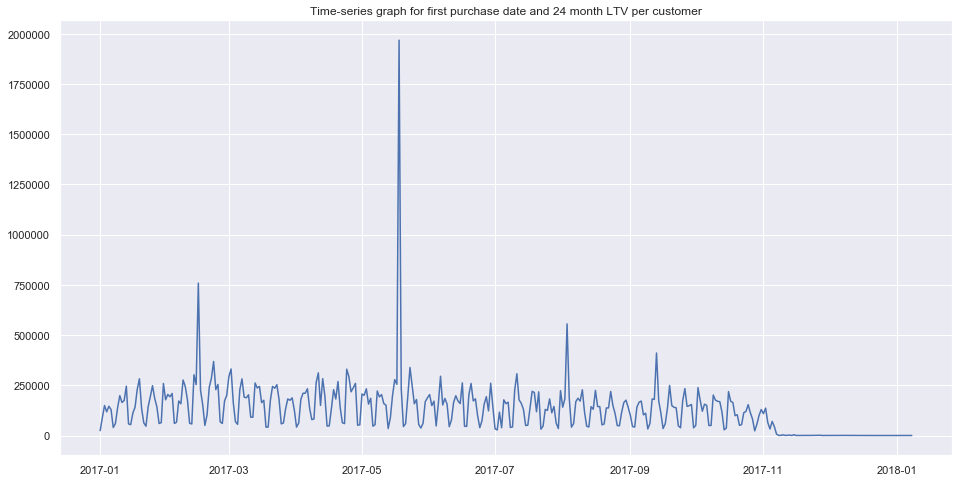

In [29]:
## plot timeseries data set
plt.figure(figsize=(16, 8))
plt.plot(ts_df2.revenue_24m)
plt.title('Time-series graph for first purchase date and 24 month LTV per customer')
plt.show()

See some peaks but it may be only high valued customers.Let's do a weekly trends by applying 7days moving average to smooth out the weekends dropping.

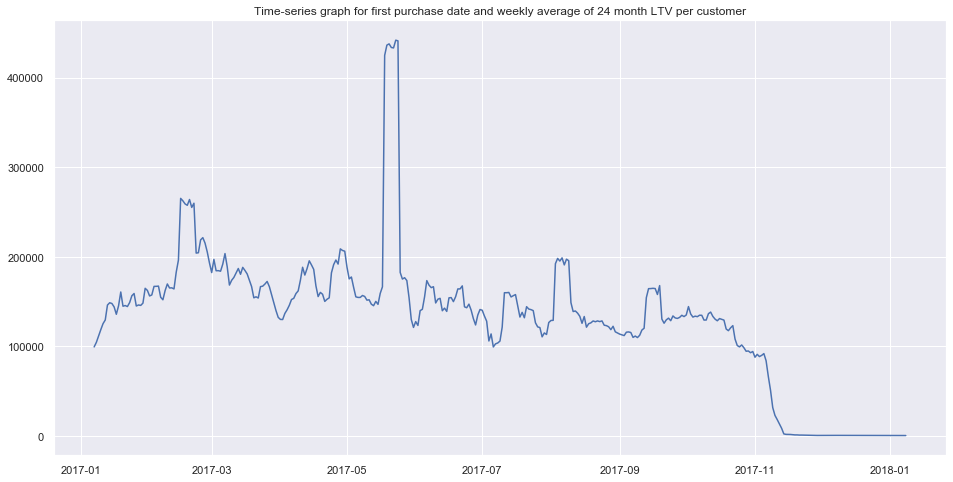

In [30]:
# create 7-day moving average
ts_df2['avg_7day']=ts_df2.iloc[:,0].rolling(window=7).mean()

## plot timeseries data set
plt.figure(figsize=(16, 8))
plt.plot(ts_df2.avg_7day)
plt.title('Time-series graph for first purchase date and weekly average of 24 month LTV per customer')
plt.show()

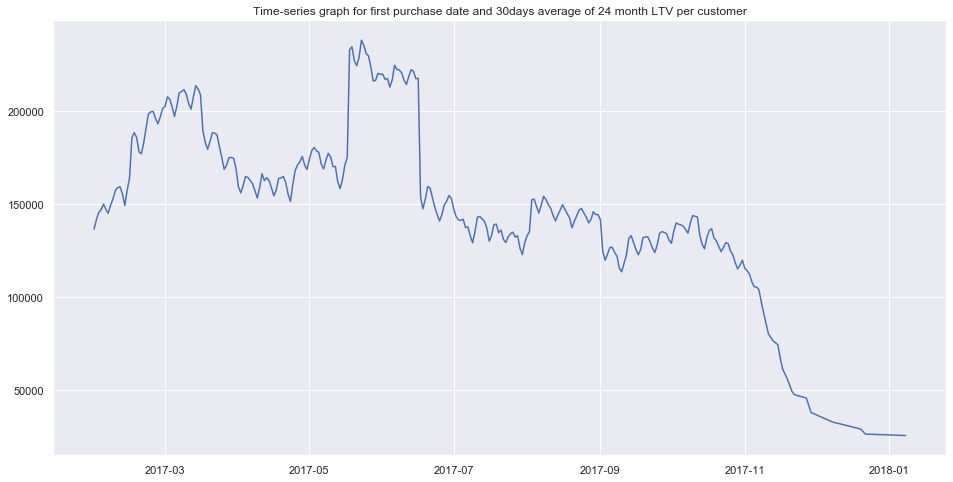

In [31]:
# what about monthly
ts_df2['avg_30day']=ts_df2.iloc[:,0].rolling(window=30).mean()

## plot timeseries data set
plt.figure(figsize=(16, 8))
plt.plot(ts_df2.avg_30day)
plt.title('Time-series graph for first purchase date and 30days average of 24 month LTV per customer')
plt.show()

Still see the peaks during the June which is the peak season for the business. Nothing really surprised us so far.

### 3. Can you make a bar plot or a histogram? Can you compare two related quantities? 
check categorical features and target predictive value

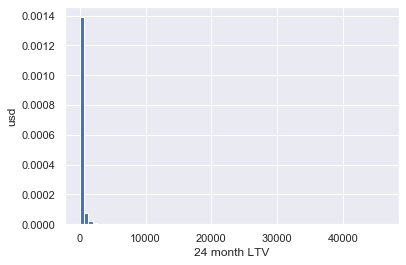

<Figure size 5760x2880 with 0 Axes>

In [38]:
_ = plt.hist(customer_df.revenue_24m, bins=70, normed= True)
_ = plt.xlabel('24 month LTV')
_ = plt.ylabel('usd')
_ = plt.figure(figsize=(80,40))

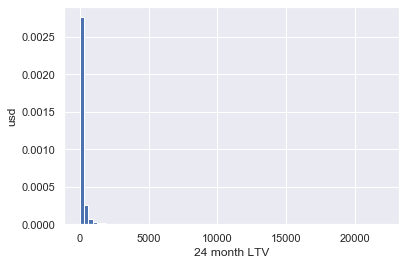

<Figure size 5760x2880 with 0 Axes>

In [39]:
_ = plt.hist(customer_df.first_order_total_revenue, bins=70, normed= True)
_ = plt.xlabel('24 month LTV')
_ = plt.ylabel('usd')
_ = plt.figure(figsize=(80,40))

count    171781.000000
mean        280.234717
std         819.061004
min           0.590000
25%          51.950000
50%         103.380000
75%         239.320000
max       46285.480000
Name: revenue_24m, dtype: float64


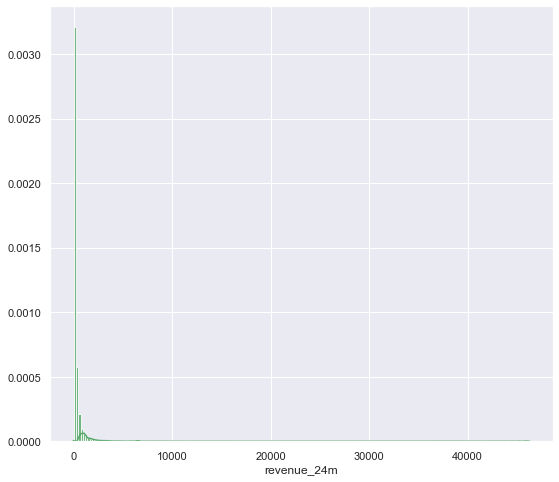

In [40]:
print(customer_df['revenue_24m'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(customer_df.revenue_24m, color='g', bins=200, hist_kws={'alpha': 0.8});

count    171781.000000
mean        189.639499
std         402.260859
min           0.590000
25%          47.470000
50%          86.010000
75%         184.080000
max       22096.750000
Name: first_order_total_revenue, dtype: float64


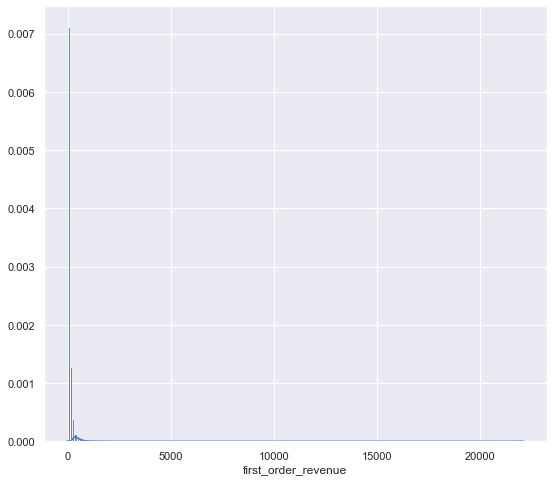

In [41]:
print(customer_df['first_order_total_revenue'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(customer_df.first_order_revenue,  bins=200,hist_kws={'alpha': 0.8});

First_order_reveue and 24m_revenue per customer are both highly skewed due to the small portion of high value customers

### Let's plot histgram for all numeric variables

In [42]:
list(set(customer_df.dtypes.tolist()))

[dtype('O'), dtype('int64'), dtype('float64'), dtype('<M8[ns]')]

In [43]:
df_num = customer_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,customer_id,fo_company_name_flag,fo_discount_flag,fo_upload_flag,sum_lifetime_net_sales,first_order_revenue,qty_first_order,first_order_total_revenue,revenue_24m
0,3822657,0.0,0.0,1.0,34.42,34.42,2.0,34.42,34.42
1,3822663,0.0,0.0,1.0,26.18,26.18,1.0,26.18,26.18
2,3822667,0.0,0.0,1.0,34.14,34.14,100.0,34.14,34.14
3,3822673,1.0,0.0,1.0,144.85,47.96,100.0,47.96,144.85
4,3822677,0.0,0.0,1.0,48.87,48.87,75.0,48.87,48.87


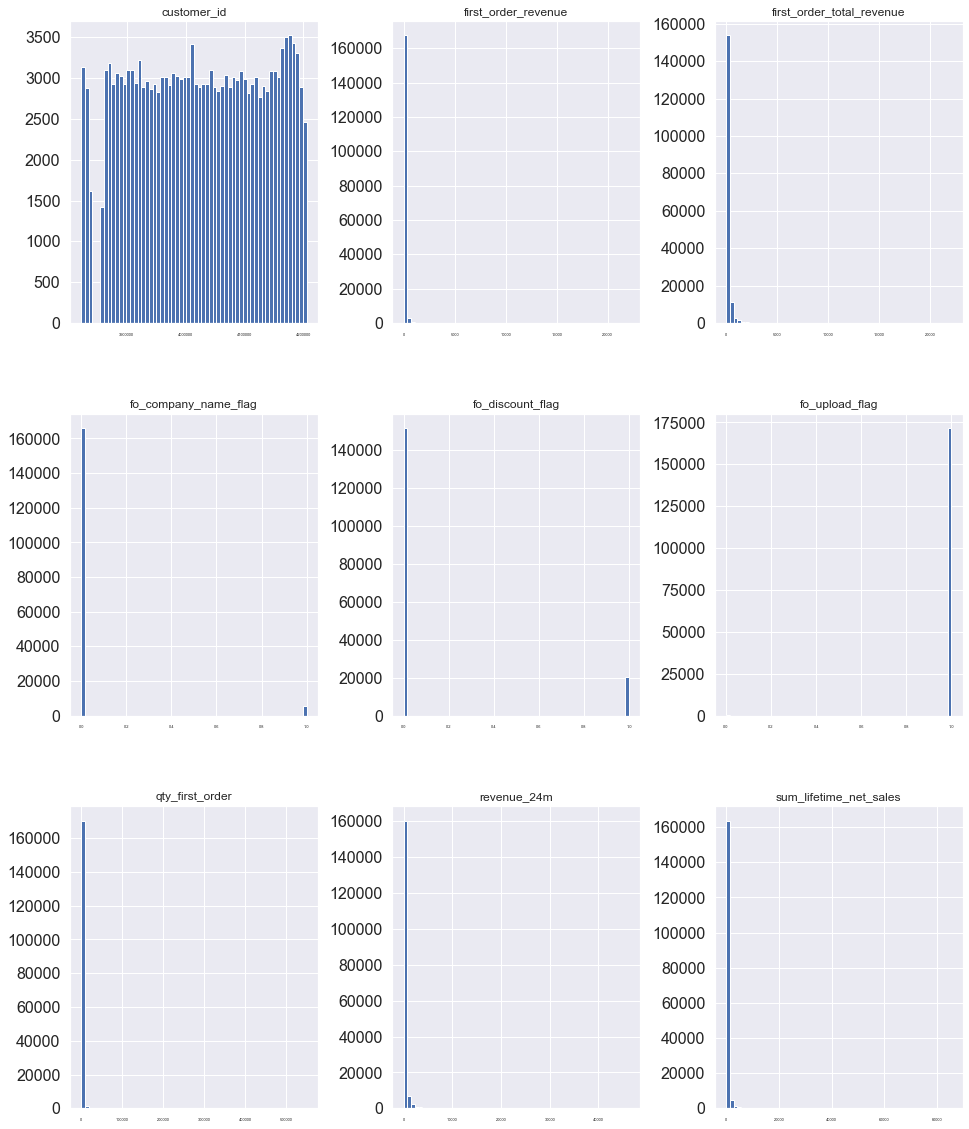

In [44]:
df_num.hist(figsize=(16, 20), bins=60, xlabelsize=4, ylabelsize=16);

Monetary variables (revenue_24m, sum_lifetime_net_sales,first_order_total_revenue and first_order_revenue) are all highly skewed. And we can tell business type customers are in a small portion (fo_company_flag=1 means customer is a company). This matches ecommerce rule: around 80% of the revenue generated by 20% customers which is business type customers here

## 4. Can you make a scatterplot? Looking at the plots, what are some insights you can make? Do you see any correlations? Let's check the correlations

1. Generate scatter plot

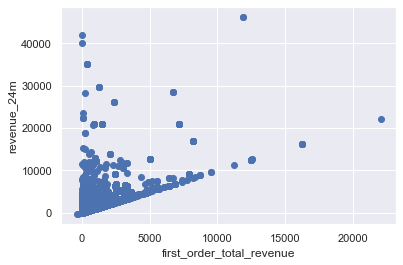

In [45]:
plt.scatter(customers[['first_order_total_revenue']], customers[['revenue_24m']], marker='o')
plt.xlabel('first_order_total_revenue')
plt.ylabel('revenue_24m')
plt.show()

It shows positive correlated, which means customers has higher 24 month LTV with larger first purchase order.

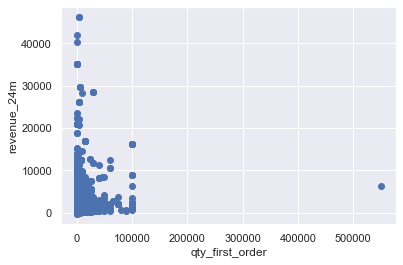

In [46]:
plt.scatter(customers[['qty_first_order']], customers[['revenue_24m']], marker='o')
plt.xlabel('qty_first_order')
plt.ylabel('revenue_24m')
plt.show()

Also shows postitive correlated but the correlation is less.

### 5. Is there a hypothesis you’d like to investigate further? 
- 1. Business type customers have higher 24m LTV
- 2. Which marketing channel is more efficient by acquiring higher 24m LTV customers?
- 3. What's my top 20 performing products
- 4. Where my majority customers are coming from?

(array([0, 1]), <a list of 2 Text xticklabel objects>)

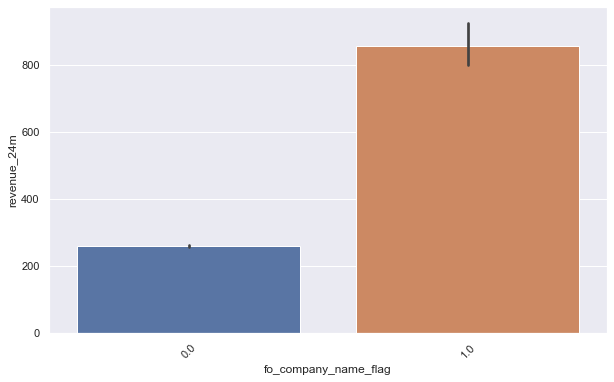

In [47]:
# 1. Business type customers have higher 24m LTV?
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='fo_company_name_flag', y='revenue_24m',  data=customer_df[['fo_company_name_flag','revenue_24m']])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

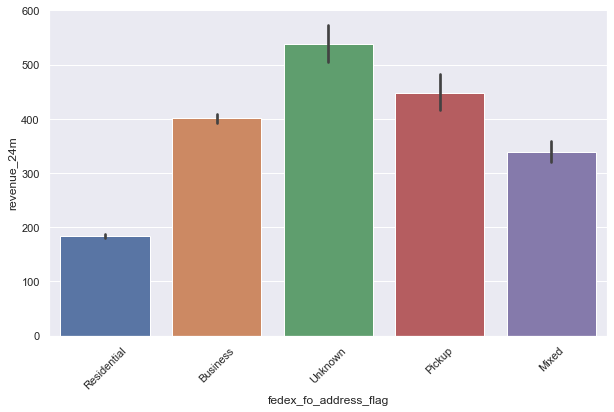

In [48]:
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='fedex_fo_address_flag', y='revenue_24m',  data=customer_df[['fedex_fo_address_flag','revenue_24m']])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

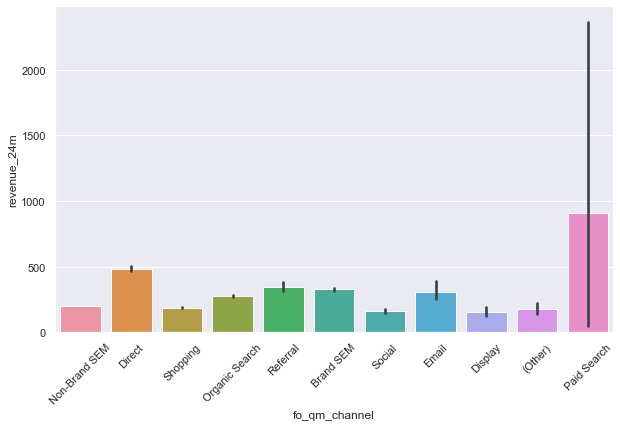

In [49]:
# 2. Which marketing channel is more efficient by acquiring higher 24m LTV customers?
plt.figure(figsize = (10, 6))
ax = sns.barplot(x='fo_qm_channel', y='revenue_24m',  data=customer_df[['fo_qm_channel','revenue_24m']])
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

In [50]:
 # 3. What's my top 20 performing products
total_ltv=customer_df['revenue_24m'].sum()
df1=customer_df.groupby('fo_f_category')['revenue_24m'].sum().reset_index()
df1['percentage%']=(df1['revenue_24m']/total_ltv)*100
df1=df1.sort_values('percentage%', ascending=False)
df1.head(15)

,fo_f_category,revenue_24m,percentage%
52,Stickers,8736707.94,18.148919
29,Labels,7028928.25,14.601318
44,Posters,4682552.98,9.727151
3,Banners,3711357.72,7.709669
8,Business Cards,3569216.17,7.414396
43,Postcards,2508207.32,5.210344
22,Flyers,2431678.71,5.051369
7,Brochures,2204311.49,4.579055
26,Hang Tags,1496217.50,3.108119
32,Magnets,1462358.72,3.037784


In [51]:
 # 4. Where my majority customers are coming from?
total_cnt=customer_df.shape[0]
df1=customer_df.groupby('state_or_province')['customer_id'].count().reset_index()
df1['percentage%']=(df1['customer_id']/total_cnt)*100
df1=df1.sort_values('percentage%', ascending=False)
df1.head(10)

,state_or_province,customer_id,percentage%
5,CA,15605,9.084241
47,TX,7094,4.129677
10,FL,6148,3.578976
37,NY,5874,3.419470
16,IL,2922,1.701003
42,PA,2807,1.634057
11,GA,2764,1.609025
30,NC,2621,1.525780
6,CO,2576,1.499584
34,NJ,2545,1.481538


## 6. What other questions do the insights lead you to ask?
1. How do qty and monetary variables(first order revenue and 24 month LTV) distribute across categorical variables ( device/marketing channels/publishers)

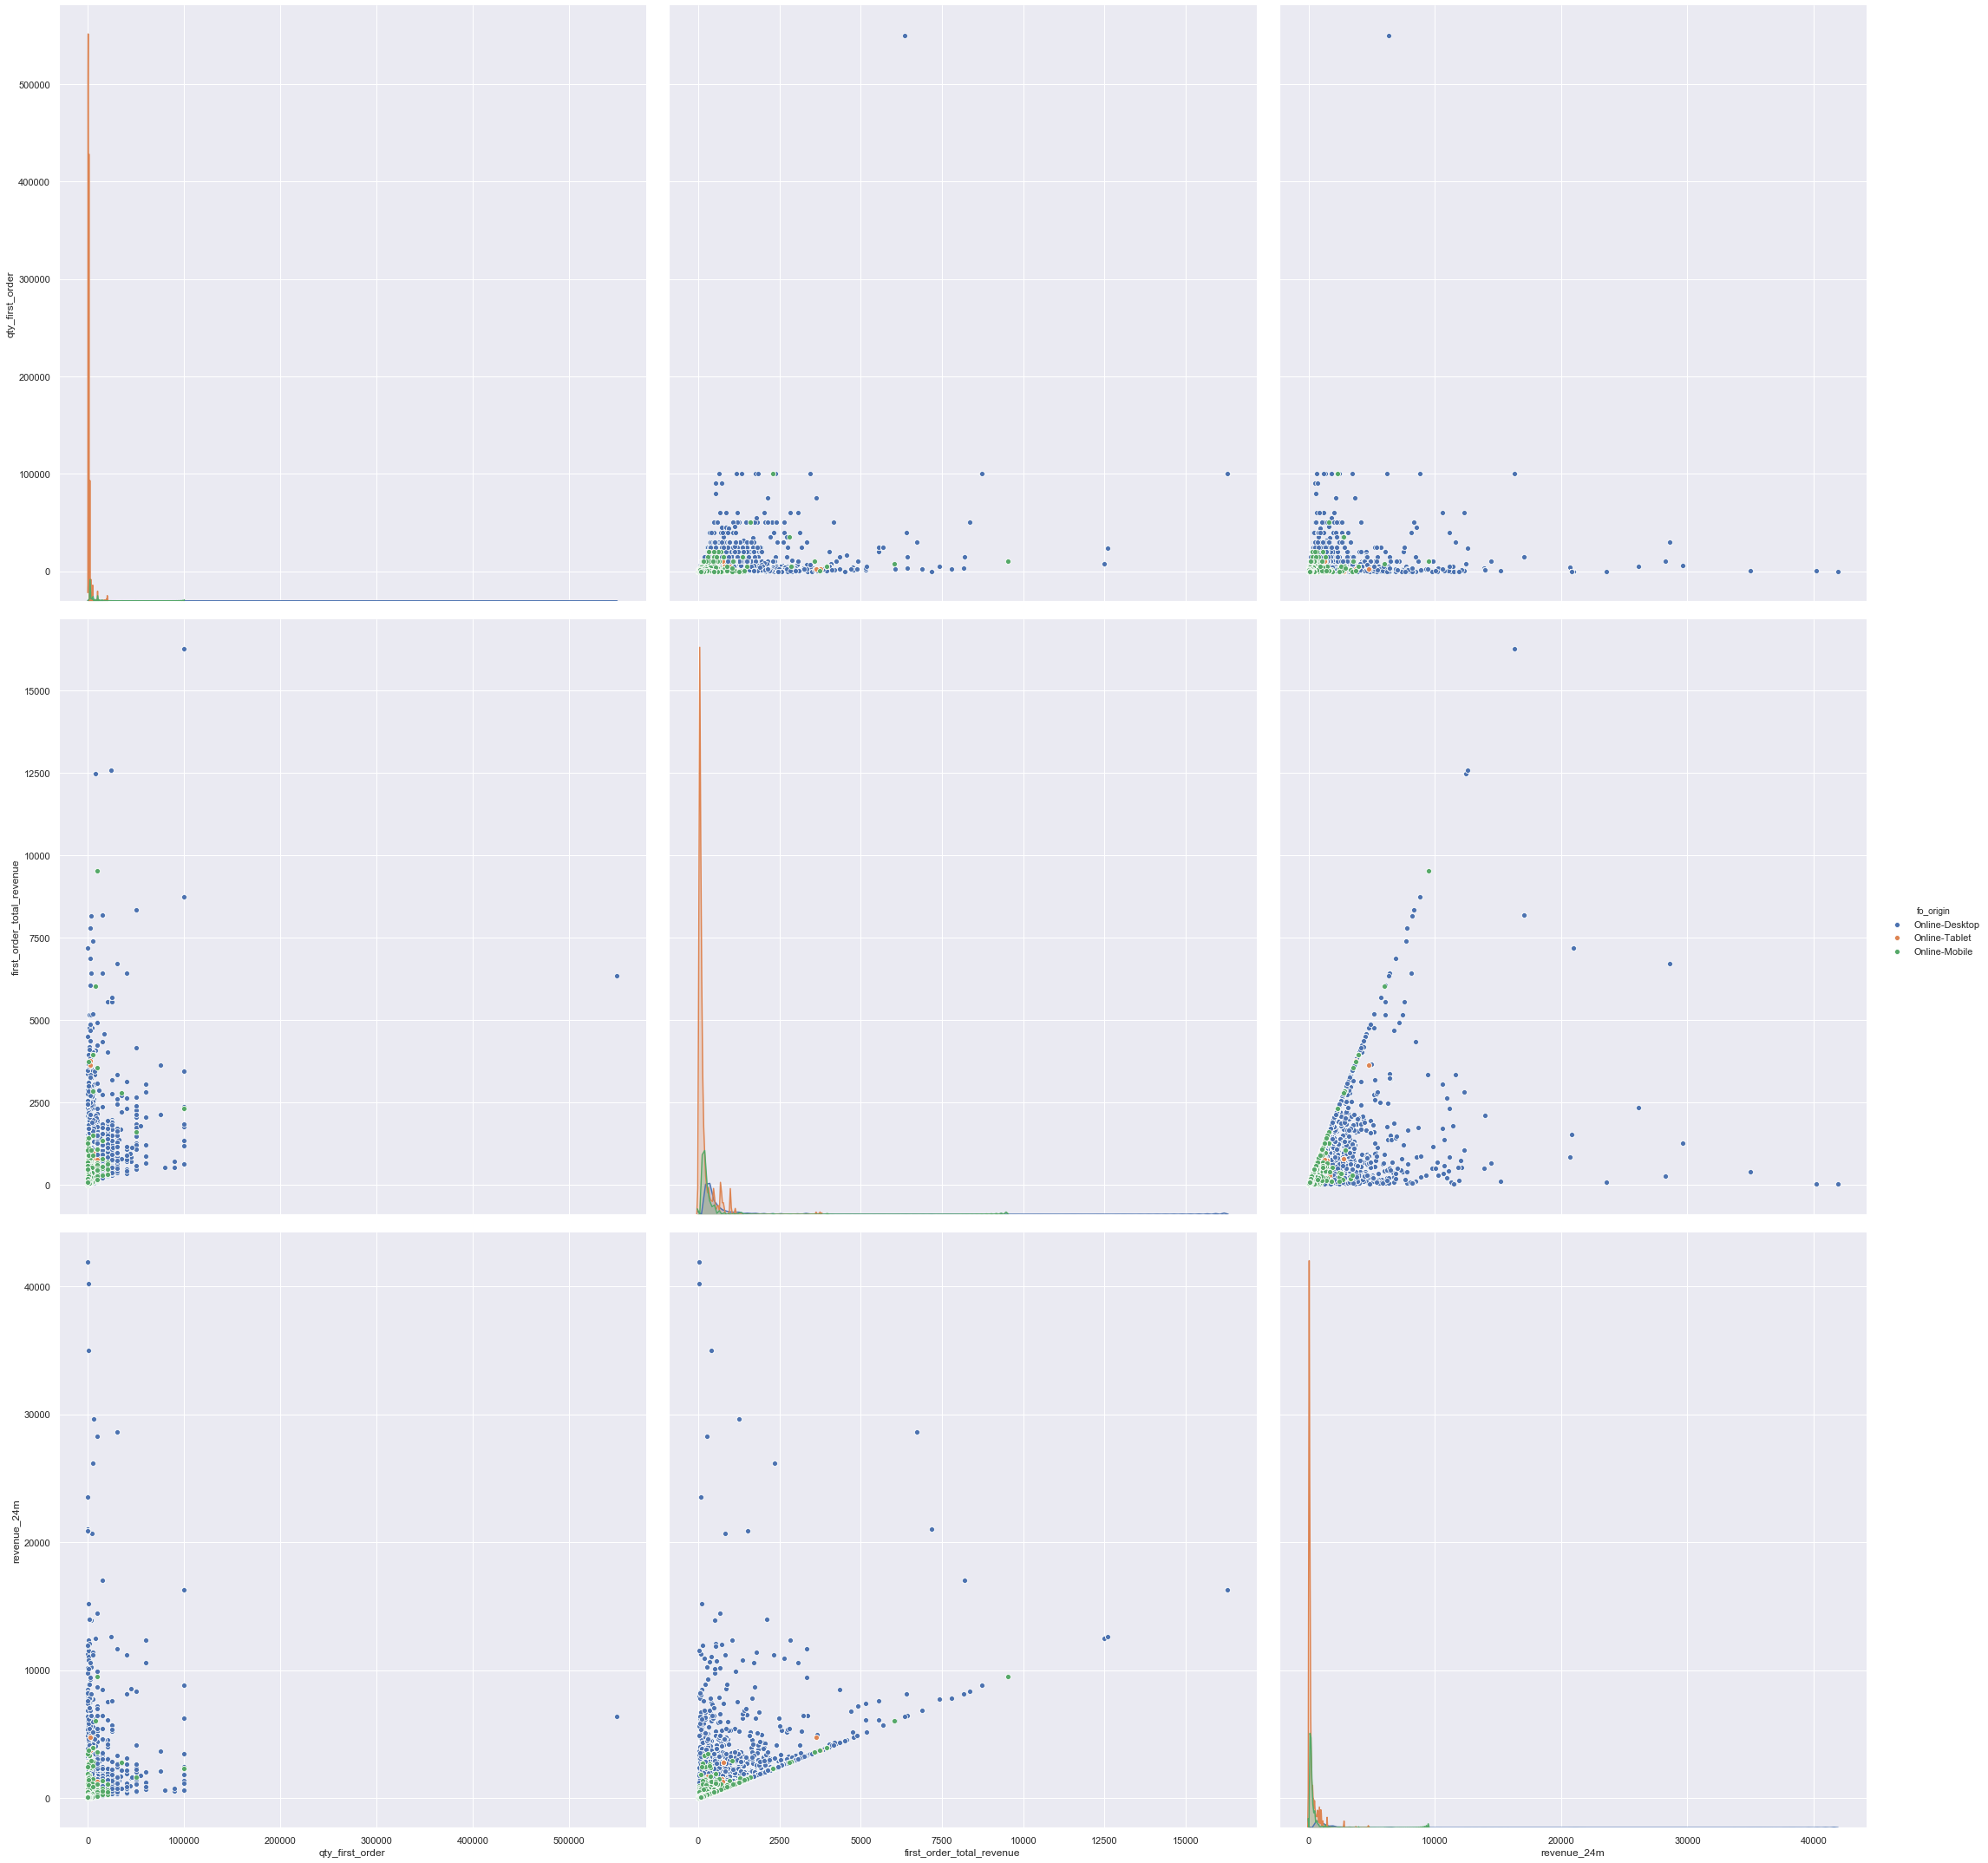

In [52]:
# plot ~ devices (desktop, mobile and tablet)
sns.pairplot(customer_df[['qty_first_order','first_order_total_revenue','revenue_24m','fo_origin']], 
                   hue='fo_origin',height=10)

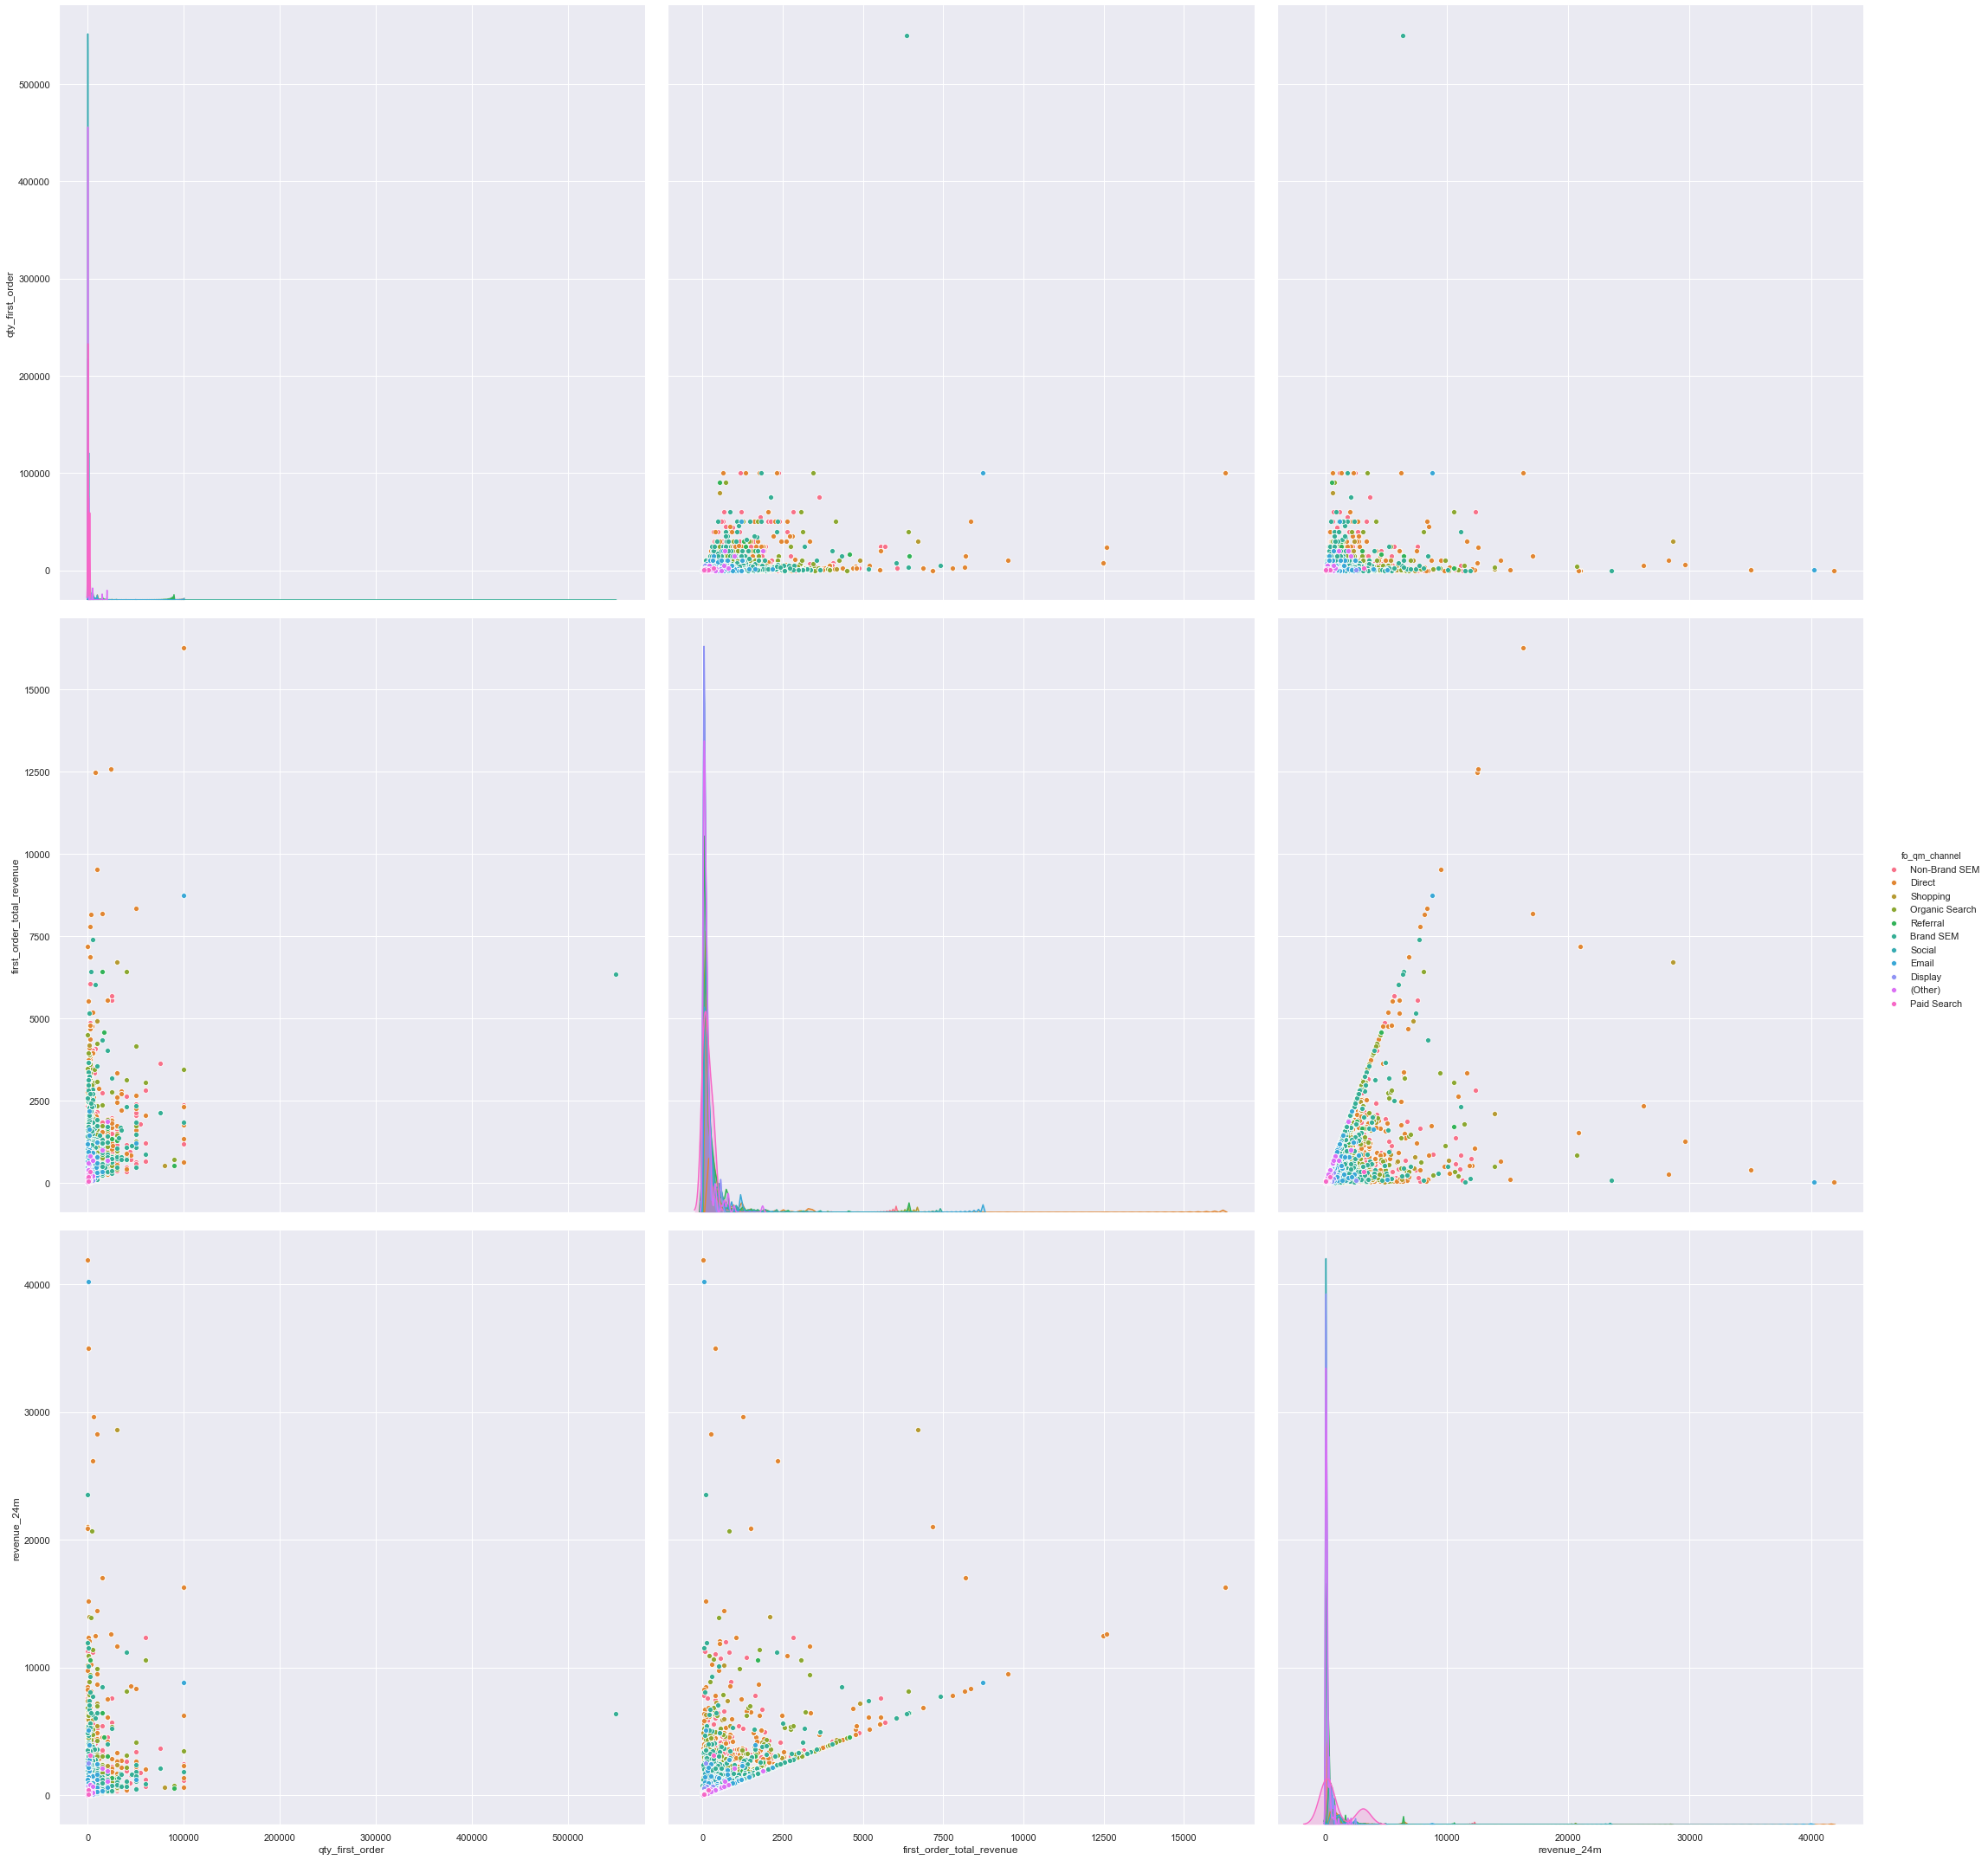

In [53]:
# plot ~ marketing channels (desktop, mobile and tablet)
sns.pairplot(customer_df[['qty_first_order','first_order_total_revenue','revenue_24m','fo_qm_channel']], 
                   hue='fo_qm_channel',height=10)

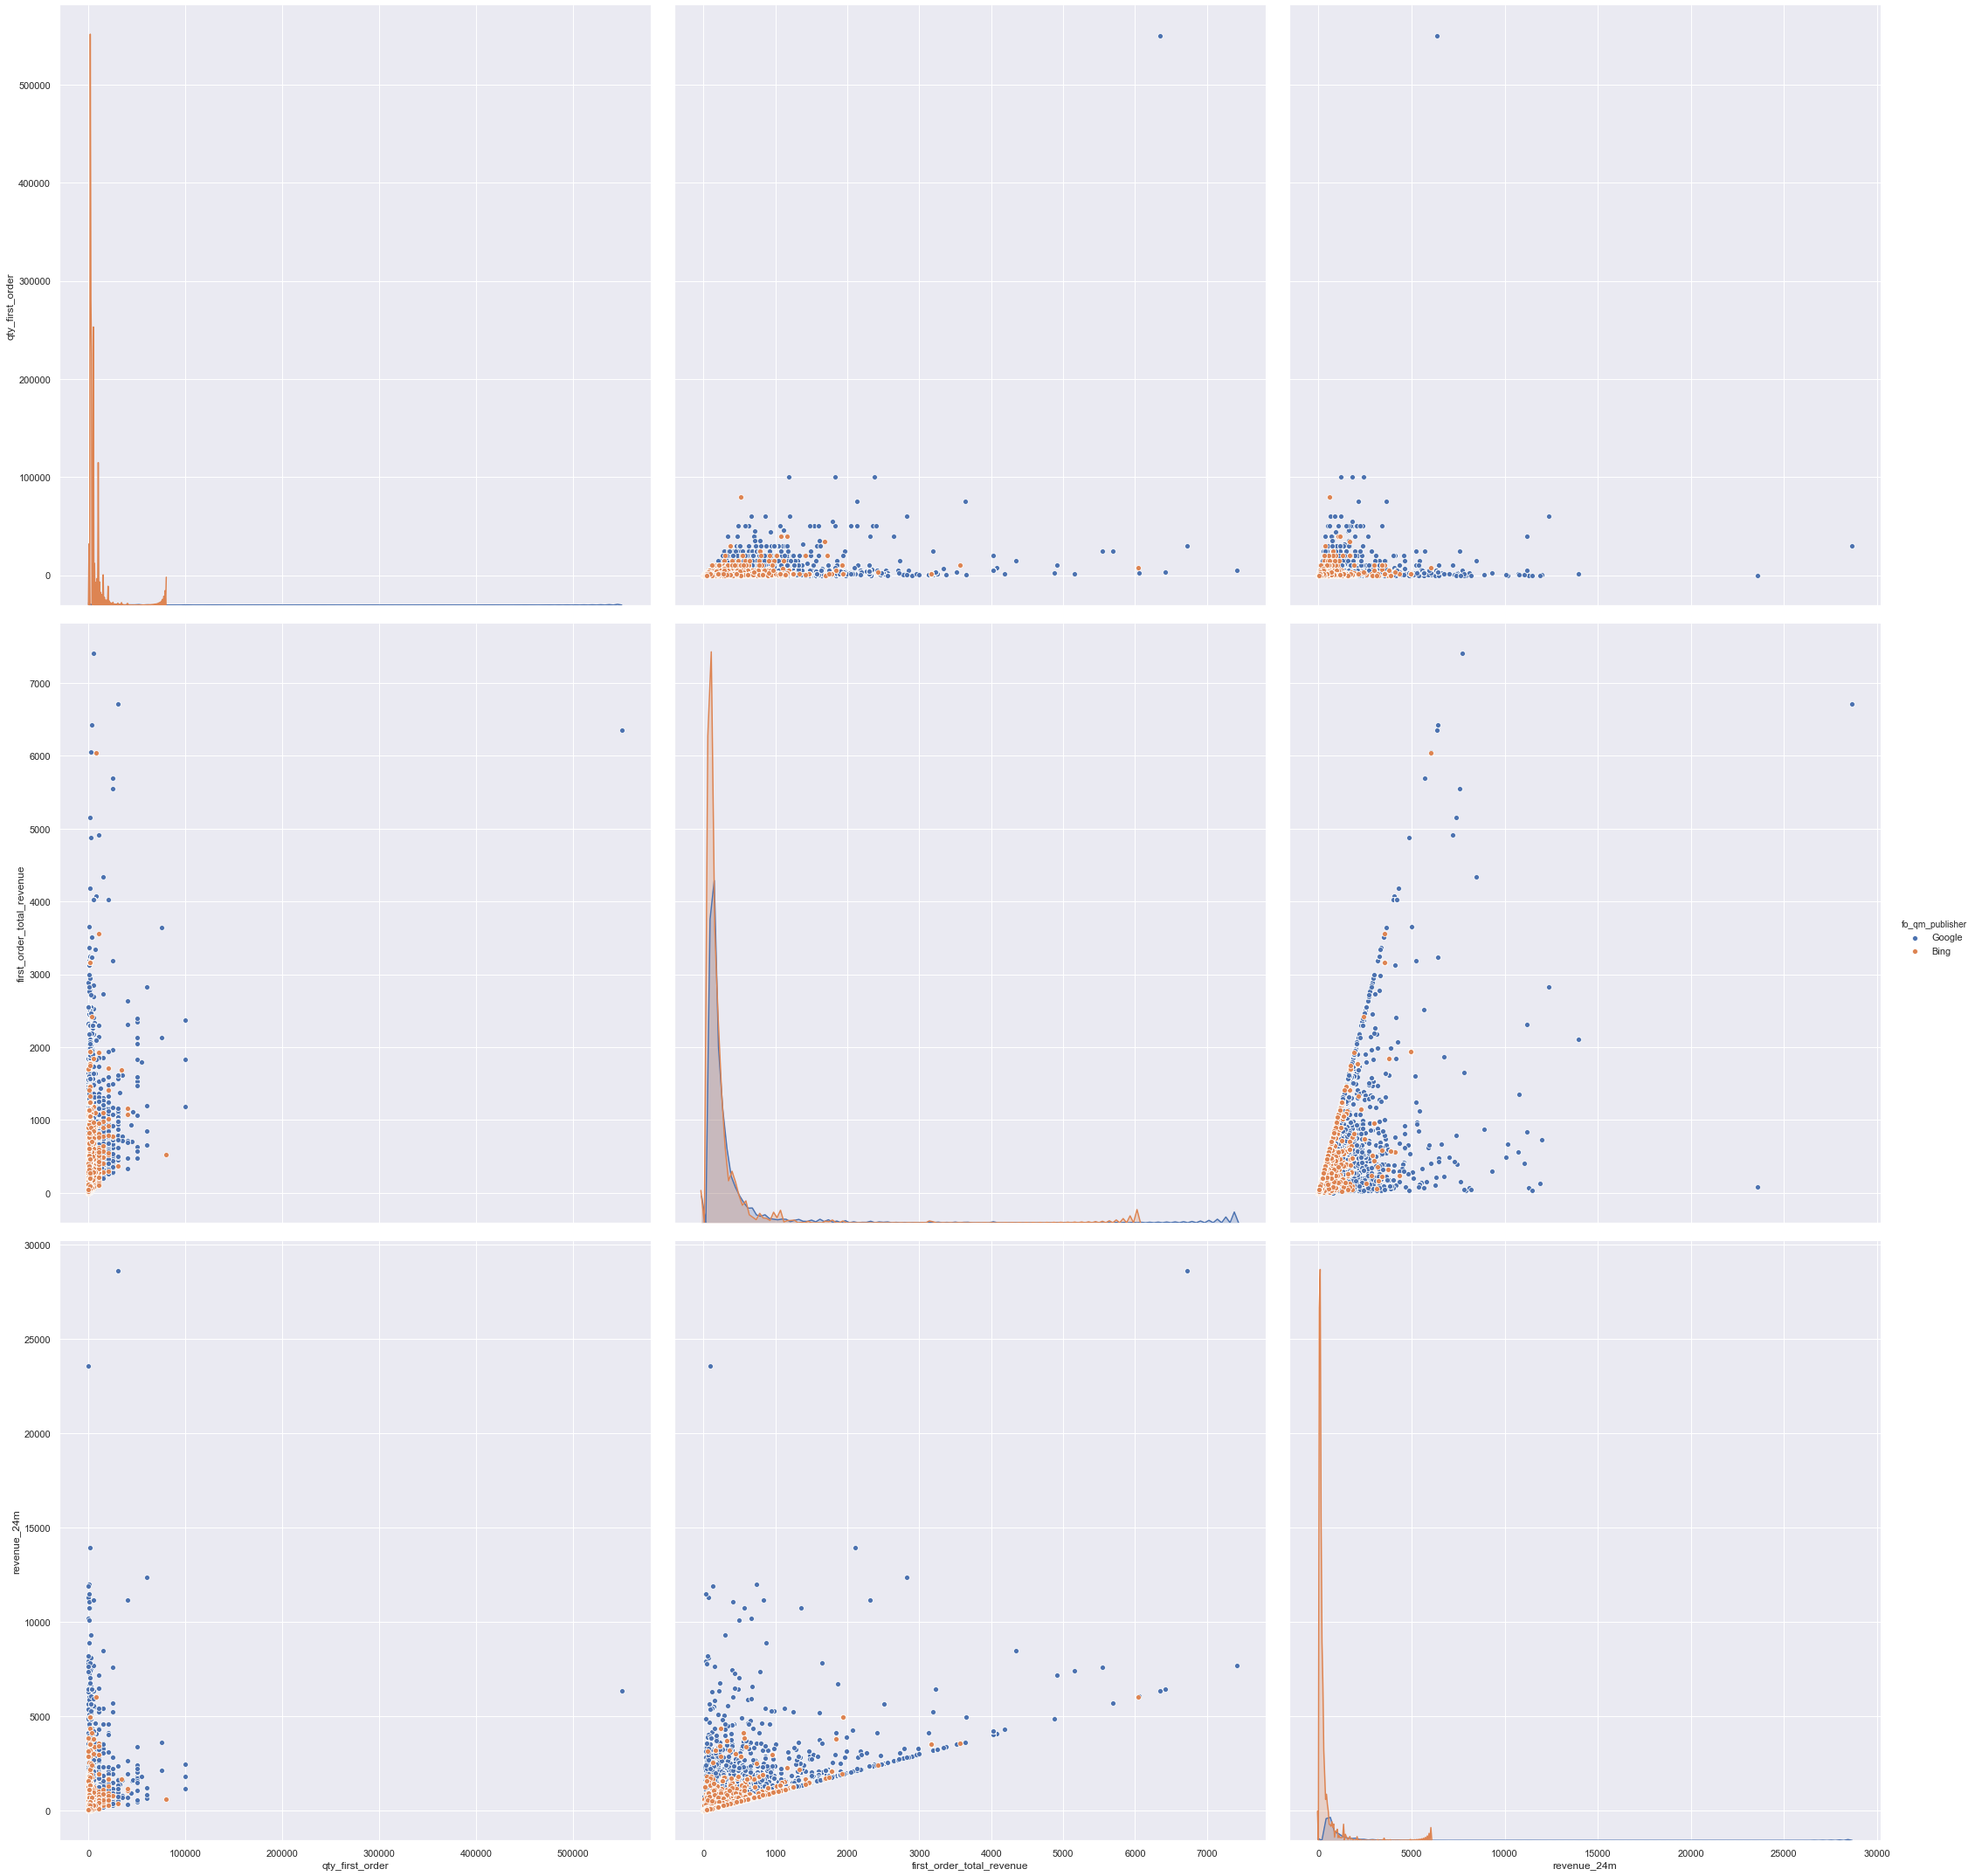

In [54]:
# plot ~ Ads publishers(Google and Bing)
sns.pairplot(customer_df[['qty_first_order','first_order_total_revenue','revenue_24m','fo_qm_publisher']], 
                   hue='fo_qm_publisher',height=10)

### Check correlations  matrix 

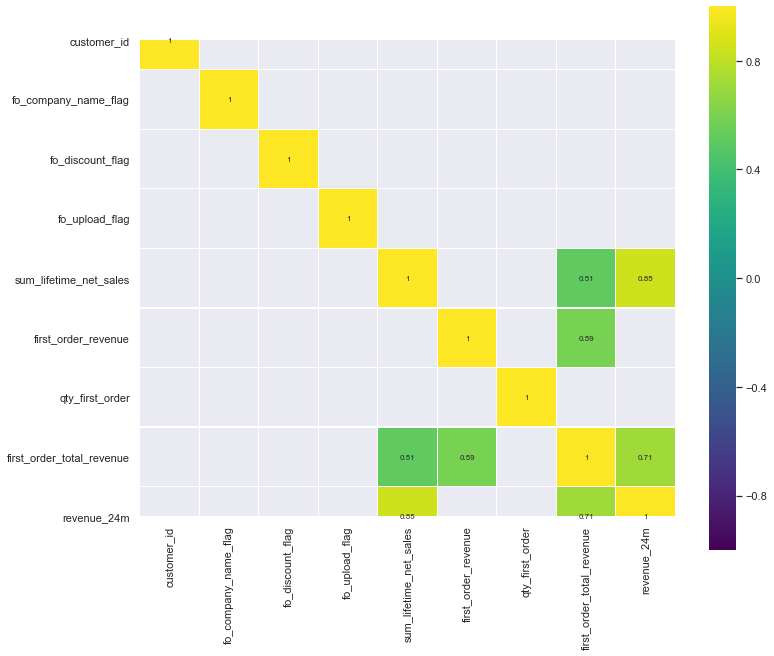

In [59]:
corrMatrix = customer_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corrMatrix[(corrMatrix >= 0.5) | (corrMatrix <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

### Check correlations matrix between features (without target variable)

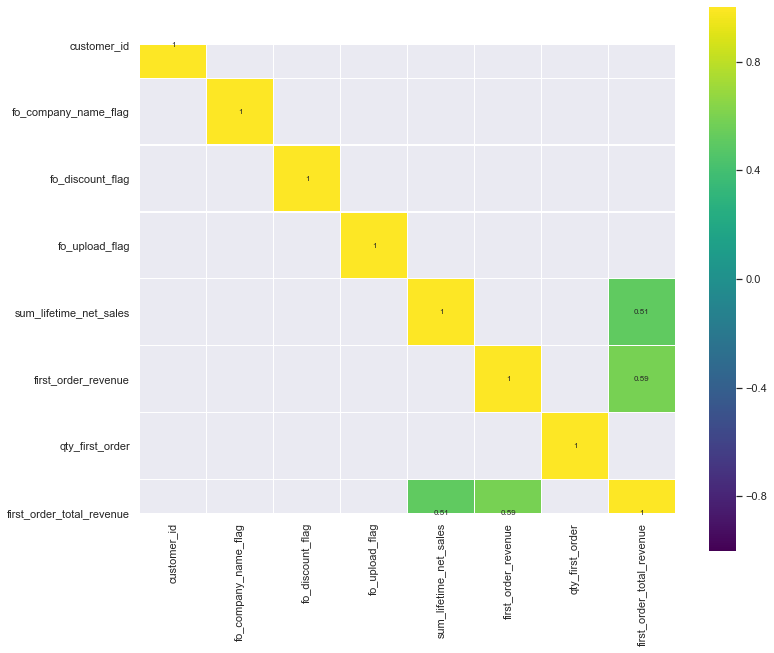

In [60]:
corr= customer_df.drop('revenue_24m', axis=1).corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);